In [1]:
#Import (not all were used, nice to have them just in case)
import os
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objects as go
import itertools
import statsmodels.api as sm
import pmdarima
from pmdarima import auto_arima
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
#DataFrame
df = pd.read_csv("C:/Users/xxxXXXxxx/Desktop/data_sets/stores_sales_forecasting.csv", encoding = 'latin1')

In [3]:
#Drop rows in Dataframe and convert 'Order Date' to datetime. Create monthly_sales
df=df.drop(columns=['Row ID', 'Order ID', 'Country', 'Ship Date', 'Ship Mode', 'Customer ID',
                    'Customer Name', 'Segment', 'Country', 'City', 'Postal Code', 'Product ID',
                   'Product Name', 'Sub-Category', 'Category', 'Region', 'State'])
df = df.drop_duplicates()
df['Order Date'] = pd.to_datetime(df['Order Date'])
df.set_index('Order Date', inplace=True)
monthly_sales = df['Sales'].resample('M').sum()

In [4]:
#Check monthly_sales
monthly_sales
len(monthly_sales)

48

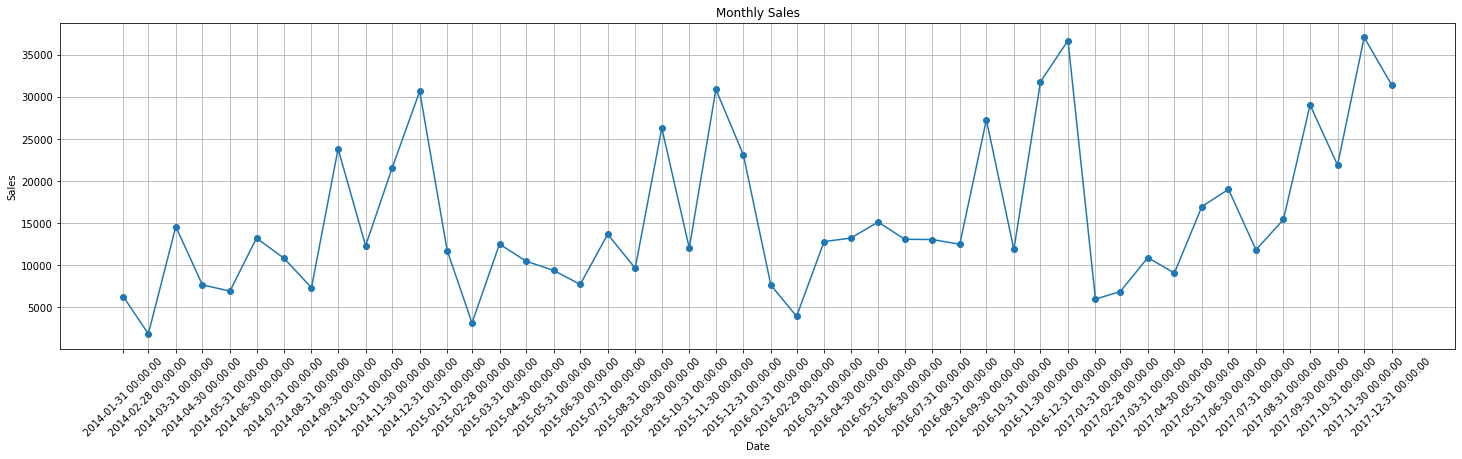

In [5]:
#Create line graph of monthly_sales
plt.figure(figsize=(25,6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
plt.xticks(ticks=monthly_sales.index, labels=monthly_sales.index, rotation=45)
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [6]:
#Establish Train and Test
train_size = int(len(monthly_sales[:48])*0.8)
train, test = monthly_sales[:train_size], monthly_sales[train_size:]

In [7]:
# Define hyperparameter values to search within a default range
p_vals = range(0, 3)  # AR order - Default range(0,3)
d_vals = range(0, 2)  # Differencing order - Default range(0,2)
q_vals = range(0, 3)  # MA order - Default range (0,3)
P_vals = range(0, 3)  # Seasonal AR order - Default range (0,3)
D_vals = range(0, 1)  # Seasonal differencing order - Default range (0,1)
Q_vals = range(0, 3)  # Seasonal MA order - Default range (0,3)

best_score = float('inf')
best_params = None

In [8]:
# Iterate all possible SARIMA hyperparameter combinations. Print best SARIMA hyperparameters.
for p, d, q, P, D, Q in itertools.product(p_vals, d_vals, q_vals, P_vals, D_vals, Q_vals):
    try:
        model = sm.tsa.SARIMAX(monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, 12))
        results = model.fit()
        aic = results.aic
        if aic < best_score:
            best_score = aic
            best_params = (p, d, q, P, D, Q)
    except:
        continue

print(f"Best SARIMA hyperparameters: {best_params} (AIC: {best_score:.2f})")
warnings.filterwarnings('ignore')

Best SARIMA hyperparameters: (0, 1, 1, 2, 0, 0) (AIC: 964.68)


In [9]:
#SARIMA
smodel=sm.tsa.SARIMAX(train,order=(0,1,1),seasonal_order=(2,0,0,12)).fit()

In [10]:
#Create forecast
forecast = results.get_forecast(steps=12)

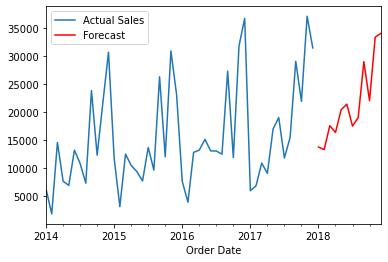

In [11]:
#Create line graph of model
monthly_sales.plot(label='Actual Sales')
forecast.predicted_mean.plot(label='Forecast', color='red')
plt.legend()
plt.show()

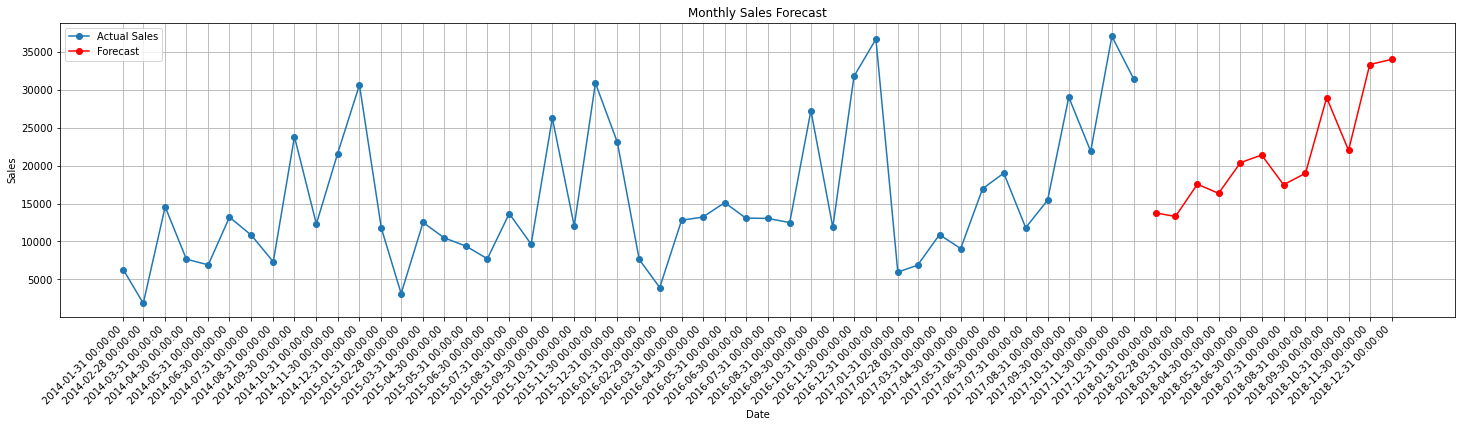

In [12]:
#Create more detailed line graph of model
combined_index = monthly_sales.index.append(forecast.predicted_mean.index)
plt.figure(figsize=(25,6))
plt.plot(monthly_sales.index, monthly_sales.values, label='Actual Sales', marker='o', linestyle='-')
forecast.predicted_mean.plot(label='Forecast', marker='o', color='red')
plt.xticks(ticks=combined_index, labels=combined_index, rotation=45)
plt.title('Monthly Sales Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [17]:
#Create csv files of monthly_sales and the forecasted model data to use in making a tableau dashboard
results=pd.DataFrame(index=monthly_sales.index, data=monthly_sales.values)
results.to_csv('C:/Users/xxxXXXxxx/Desktop/data_sets/TableauForecast.csv')

future=pd.DataFrame(index=forecast.predicted_mean.index, data=forecast.predicted_mean.values)
future.to_csv('C:/Users/xxxXXXxxx/Desktop/data_sets/TableauFuture.csv')